# Exploratory Data Analysis: METR-LA Traffic Speed Dataset

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks

import h5py
import os

import warnings
warnings.filterwarnings('ignore')

### Changing Current Working Directory

In [12]:
import os
print(os.getcwd())

os.chdir("../")

print(os.getcwd())

c:\Users\ag45092\Ankit\Traffic Prediction\notebooks
c:\Users\ag45092\Ankit\Traffic Prediction


## Data loading

### Structure of the data

In [40]:
data_path = 'data/METR-LA.h5'

with h5py.File(data_path, 'r') as f:
    def print_structure(name, obj):
        print(name, type(obj))
        if hasattr(obj, 'shape'):
            print(f"  Shape: {obj.shape}, Dtype: {obj.dtype}")
    
    f.visititems(print_structure)

df <class 'h5py._hl.group.Group'>
df/axis0 <class 'h5py._hl.dataset.Dataset'>
  Shape: (207,), Dtype: |S6
df/axis1 <class 'h5py._hl.dataset.Dataset'>
  Shape: (34272,), Dtype: int64
df/block0_items <class 'h5py._hl.dataset.Dataset'>
  Shape: (207,), Dtype: |S6
df/block0_values <class 'h5py._hl.dataset.Dataset'>
  Shape: (34272, 207), Dtype: float64


In [41]:
with h5py.File(data_path, 'r') as f:
    data = np.array(f['df/block0_values'], dtype=np.float32)
    timestamps_raw = np.array(f['df/axis1'])    
    sensor_ids = np.array(f['df/axis0']).astype(str)

timestamps = pd.to_datetime(timestamps_raw)

print(f"Data shape: {data.shape}")
print(f"Number of sensors: {len(sensor_ids)}")
print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
print(f"Sample sensor IDs: {sensor_ids[:5]}")
print(f"Mean speed: {np.nanmean(data):.2f} mph")

Data shape: (34272, 207)
Number of sensors: 207
Time range: 2012-03-01 00:00:00 to 2012-06-27 23:55:00
Sample sensor IDs: ['773869' '767541' '767542' '717447' '717446']
Mean speed: 53.72 mph


## Missing Value Analysis

In [56]:
missing_mask = np.isnan(data)
total_missing = np.sum(missing_mask)
print(f"Total missing values: {total_missing:,}")

Total missing values: 0


## Descriptive Analysis

In [54]:
mean_speed = np.nanmean(data)
median_speed = np.nanmedian(data)

print(f"Total Data Points: {data.size:,}")
print(f"Mean Speed: {mean_speed:.2f} mph")
print(f"Median Speed: {median_speed:.2f} mph")
print(f"Std Deviation: {np.nanstd(data):.2f} mph")
print(f"Variance: {np.nanvar(data):.2f}")

        

Total Data Points: 7,094,304
Mean Speed: 53.72 mph
Median Speed: 62.44 mph
Std Deviation: 20.26 mph
Variance: 410.53


In [58]:
flat_data = data.flatten()
valid_data = flat_data[~np.isnan(flat_data)]
sensor_means = np.nanmean(data, axis=0)
sensor_stds = np.nanstd(data, axis=0)

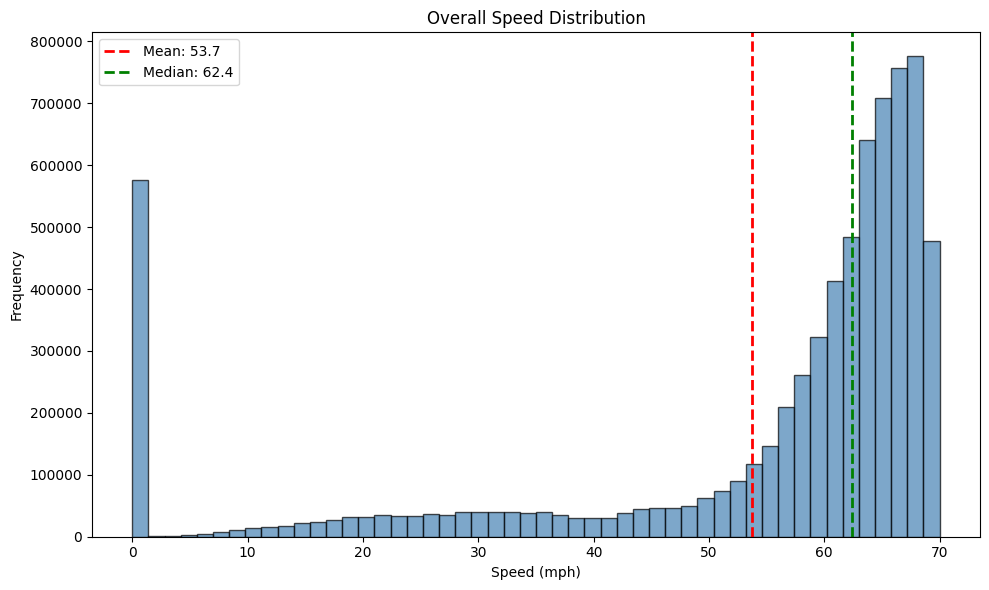

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(valid_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(valid_data), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(valid_data):.1f}')
plt.axvline(np.median(valid_data), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(valid_data):.1f}')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Overall Speed Distribution')
plt.legend()
plt.tight_layout()
plt.show()

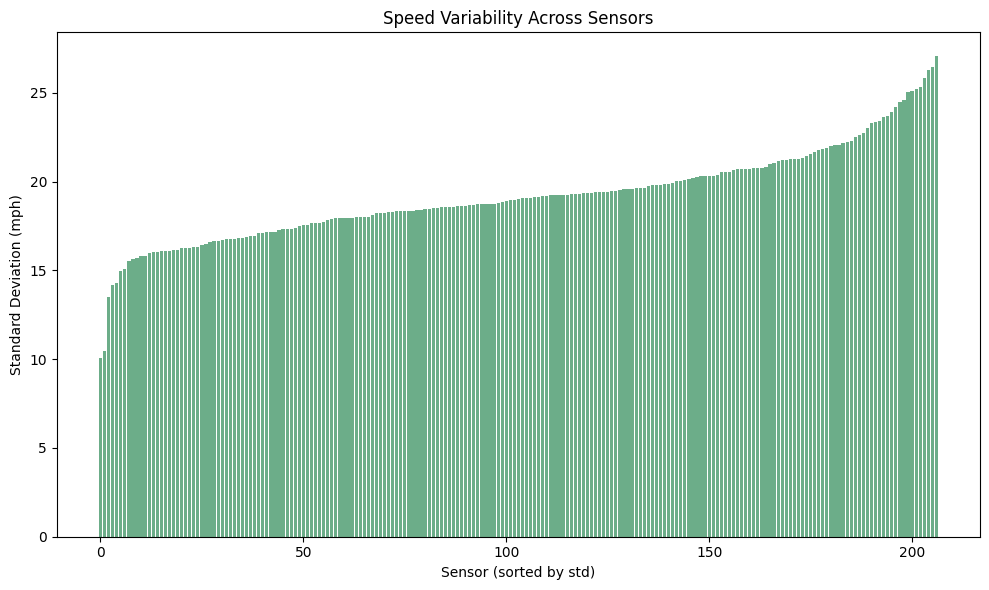

In [62]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(sensor_stds)), np.sort(sensor_stds), color='seagreen', alpha=0.7)
plt.xlabel('Sensor (sorted by std)')
plt.ylabel('Standard Deviation (mph)')
plt.title('Speed Variability Across Sensors')
plt.tight_layout()
plt.show()

## Temporal Pattern Analysis

In [64]:
df = pd.DataFrame(data)
df['timestamp'] = timestamps
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date
df['week'] = df['timestamp'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'] >= 5

df['mean_speed'] = np.nanmean(data, axis=1)

### Hourly Patterns

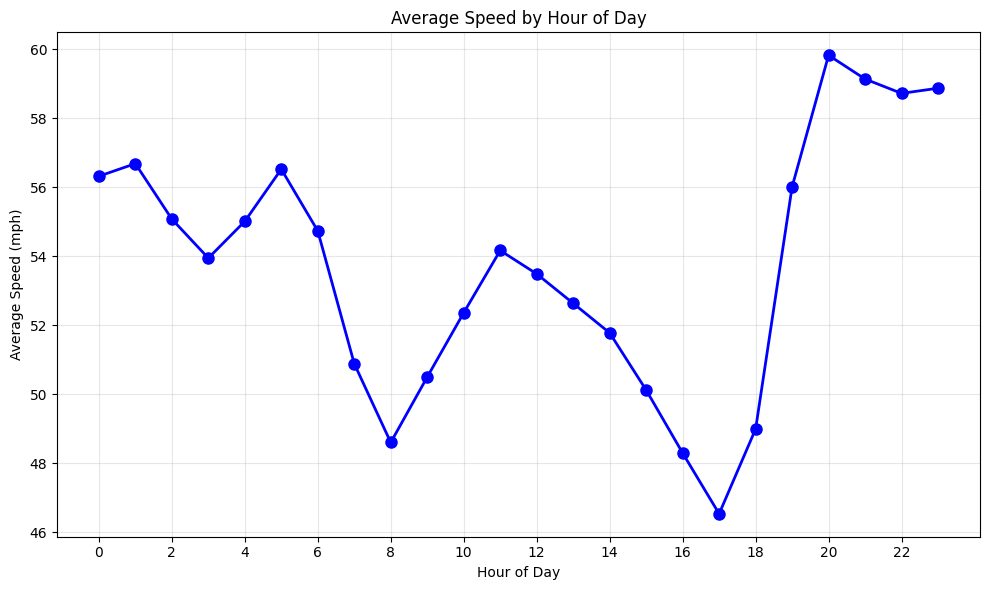

In [66]:
hourly_avg = df.groupby('hour')['mean_speed'].mean()
hourly_std = df.groupby('hour')['mean_speed'].std()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Speed by Hour of Day')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


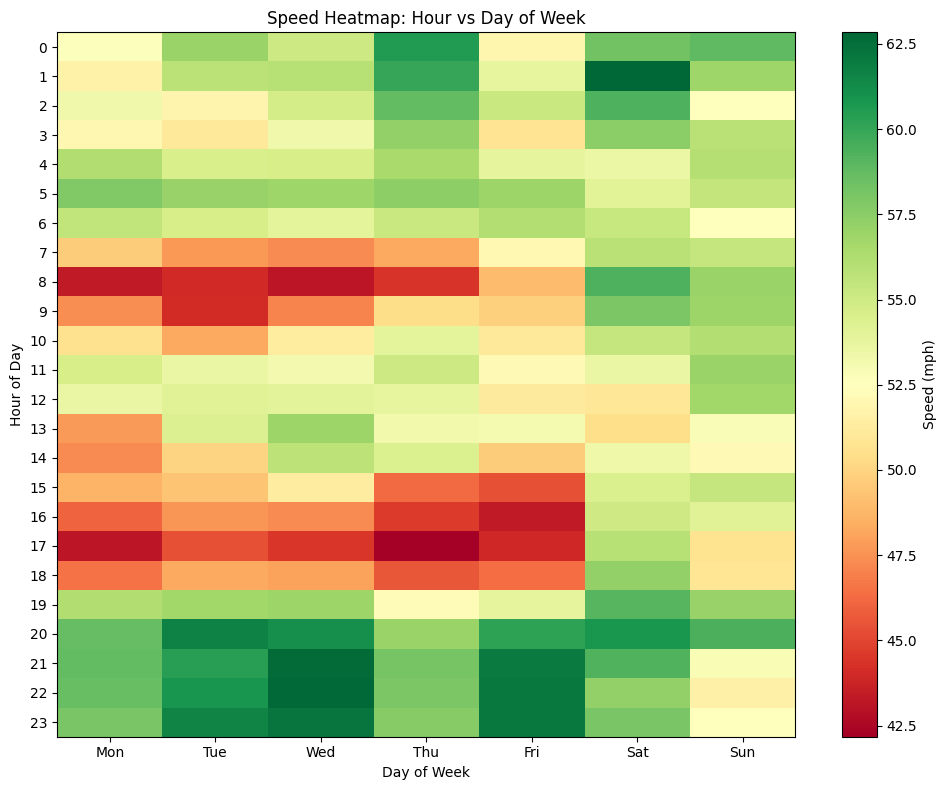

In [67]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_table = df.pivot_table(values='mean_speed', index='hour', columns='day_of_week', aggfunc='mean')
pivot_table.columns = day_names

plt.figure(figsize=(10, 8))
plt.imshow(pivot_table.values, aspect='auto', cmap='RdYlGn', interpolation='nearest')
plt.yticks(range(24), range(24))
plt.xticks(range(7), day_names)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('Speed Heatmap: Hour vs Day of Week')
plt.colorbar(label='Speed (mph)')
plt.tight_layout()
plt.show()

### Daily average speed time series

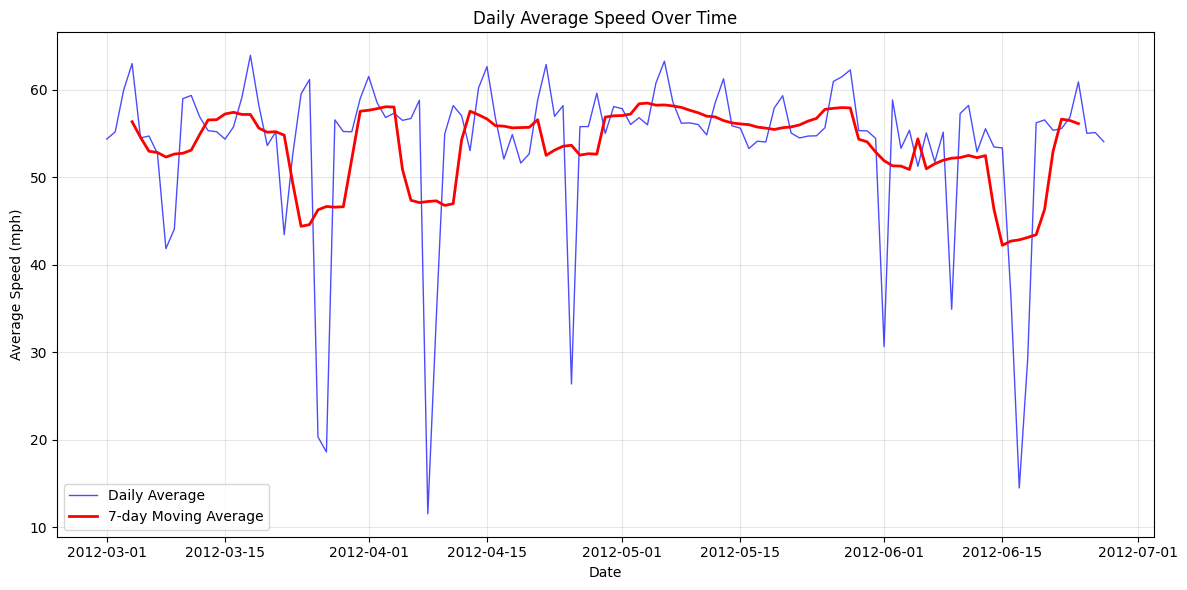

In [69]:
daily_speed = df.groupby('date')['mean_speed'].mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_speed.index, daily_speed.values, 'b-', linewidth=1, alpha=0.7, label='Daily Average')

# Add 7-day moving average
ma_7 = daily_speed.rolling(window=7, center=True).mean()
plt.plot(daily_speed.index, ma_7.values, 'r-', linewidth=2, label='7-day Moving Average')

plt.xlabel('Date')
plt.ylabel('Average Speed (mph)')
plt.title('Daily Average Speed Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Speed Distribution

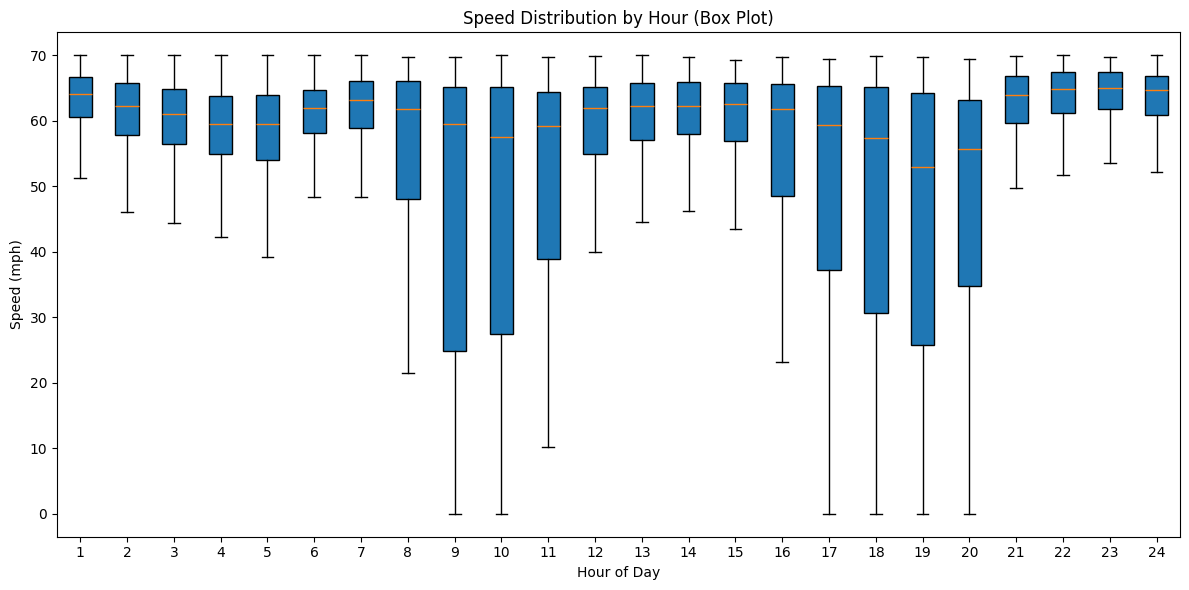

In [76]:
plt.figure(figsize=(12, 6))

hourly_data = [data[df['hour'].values == h, :].flatten() for h in range(24)]
hourly_data = [d[~np.isnan(d)][:500] for d in hourly_data]  # Sample for speed
bp = plt.boxplot(hourly_data, showfliers=False, patch_artist=True)

plt.xlabel('Hour of Day')
plt.ylabel('Speed (mph)')
plt.title('Speed Distribution by Hour (Box Plot)')

plt.tight_layout()
plt.show()


## Summary & Key Takeaways

**1. Rush Hours are Real**
The data clearly shows two congestion periods - morning rush around 8 AM and evening rush between 5-7 PM. Evening rush is actually worse, with speeds dropping to around 46-48 mph on average.

**2. Weekends are Noticeably Better**
The heatmap tells the story - Saturday and Sunday are mostly green (higher speeds) while weekdays, especially Monday through Friday, show the classic red zones during commute hours.

**3. Night Driving is Fastest**
Speeds peak around 8-10 PM and stay high through the early morning hours (until about 6 AM). 

**4. Some Bad Days in the Data**
The daily average plot shows a few dramatic dips (speeds dropping to 10-20 mph for entire days).

**5. High Variability During Rush Hours**
The box plots show that during peak hours, speeds can range anywhere from 0 to 65+ mph. This high variance will make prediction harder during these times - the model will likely have higher errors during rush hours.